In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

import torch
import torch.nn as nn
import joblib

sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [2]:
pot_id = "100pct_3day-removed"
pot_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{pot_id}_outputs"


In [3]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [43]:
model_pot = MLP(10)
model_pot.load_state_dict(torch.load(f'{pot_path}/model_{pot_id}.pt'))
model_pot.eval()



MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [44]:
#Load omni data
omni_data = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
omni_data = omni_data[omni_data['Timestamp_1min_omni'] == '1999-10-01 00:00:00']
#omni_data = omni_data[omni_data['Timestamp_1min_omni'].between('1999-10-01 00:00:00', '1999-10-07 23:55:00')]
omni_data

#mean over 1 hr 
omni_data['Timestamp_1min_omni'] = pd.to_datetime(omni_data['Timestamp_1min_omni'])
omni_data = omni_data.set_index('Timestamp_1min_omni')
omni_data = omni_data.resample('1h').mean(numeric_only=True)
omni_data = omni_data.reset_index()
omni_data

,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,F10.7,Kp,tilt_angle
0,1999-10-01,1.84,0.66,485.0,4.17,178.0,-100.0,79.0,121.900002,23.0,-0.115365


In [120]:
def split_to_df(df):
     
    df = df.copy()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #create grid of lat and lon
    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

    def calculate_delta(lat1, lon1, lat2, lon2):
        radius = 6371.008 * 1e3

        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        l = 2 * np.pi * radius
        
        delta_x = dlat * (l/360)
        delta_y = dlon * (l/360) * np.cos(np.radians(lat1))
        
        return delta_x, delta_y
    
    d_x = []
    d_y = []

    for i in range(len(lat) - 1):
        for j in range(len(lon) - 1):
            lat1, lat2 = lat[i], lat[i + 1]
            lon1, lon2 = lon[j], lon[j + 1]
            
            delta_x, delta_y = calculate_delta(lat1, lon1, lat2, lon2)
            d_x.append(delta_x)
            d_y.append(delta_y)
            
            #area = delta_x * delta_y
            #areas[i, j] = area
    delta_x = np.array(d_x)
    delta_y = np.array(d_y)

    lat_cropped_int =np.linspace(53.1, 89.7, 29)
    lon_cropped_int = np.linspace(1.6, 357.6, 79)

    edf = pd.DataFrame()
    edf['dt'] = np.tile(df['Timestamp_1min_omni'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['delta_x'] = delta_x
    edf['delta_y'] = delta_y
    edf['lat'] = np.tile(lat_cropped_int, len(lon_cropped_int))
    edf['lon'] = np.repeat(lon_cropped_int, len(lat_cropped_int))
    edf['BY_GSE'] = np.tile(df['BY_GSE'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['BZ_GSE'] = np.tile(df['BZ_GSE'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['flow_speed'] = np.tile(df['flow_speed'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['proton_density'] = np.tile(df['proton_density'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['tilt_angle'] = np.tile(df['tilt_angle'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['F10.7'] = np.tile(df['F10.7'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['Kp'] = np.tile(df['Kp'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['AE_INDEX'] = np.tile(df['AE_INDEX'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['AL_INDEX'] = np.tile(df['AL_INDEX'], len(lat_cropped_int)*len(lon_cropped_int))
    edf['AU_INDEX'] = np.tile(df['AU_INDEX'], len(lat_cropped_int)*len(lon_cropped_int))

    edf['mlt'] = np.mod(edf['lon'] + 12, 360) / 15

    #edf = edf[edf['lat'].between(60, 70)]


    df_2 = edf.copy()
    df_2 = df_2[['dt','mlt','lon','lat','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

    df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
    df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

    df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
    df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))


    df_2 = df_2.drop(columns=['dt'])

    return edf, df_2

df_raw, df_proc = split_to_df(omni_data)
df_raw

,dt,delta_x,delta_y,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt
0,1999-10-01,140335.842259,300859.505840,53.100000,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667
1,1999-10-01,140335.842259,300859.505840,54.407143,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667
2,1999-10-01,140335.842259,300859.505840,55.714286,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667
3,1999-10-01,140335.842259,300859.505840,57.021429,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667
4,1999-10-01,140335.842259,300859.505840,58.328571,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,1999-10-01,140335.842259,13659.417968,84.471429,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000
2287,1999-10-01,140335.842259,13659.417968,85.778571,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000
2288,1999-10-01,140335.842259,13659.417968,87.085714,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000
2289,1999-10-01,140335.842259,13659.417968,88.392857,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000


In [121]:
def rescale(df, path, id):

    df = df.copy()
    
    with open(f'{path}/scaler_{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df.columns
    norm_arr = scaler.transform(df)
    df = pd.DataFrame(norm_arr, columns=col_names)
    df = df.drop(columns=['mlt','lon'])
    
    return df

df_pot = rescale(df_proc, pot_path, pot_id)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [122]:
def make_predictions(df, model):

    df = df.copy()

    df = df.to_numpy()
    
    df = torch.tensor(df, dtype=torch.float32)

    batch_size = 10000  # Adjust this value based on your system's memory capacity
    n = len(df)
    predictions = []

    for i in range(0, n, batch_size):
        batch = df[i:i+batch_size]
        batch_pred = model(batch).detach().cpu().numpy()
        batch_pred = batch_pred.flatten()
        predictions.extend(batch_pred)

    return predictions

pot_pred = make_predictions(df_pot, model_pot)


df_comp = df_raw
df_comp['pot_pred'] = pot_pred
df_comp

,dt,delta_x,delta_y,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred
0,1999-10-01,140335.842259,300859.505840,53.100000,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667,4.486856
1,1999-10-01,140335.842259,300859.505840,54.407143,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667,4.820740
2,1999-10-01,140335.842259,300859.505840,55.714286,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667,3.955744
3,1999-10-01,140335.842259,300859.505840,57.021429,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667,2.306987
4,1999-10-01,140335.842259,300859.505840,58.328571,1.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.906667,-0.337183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,1999-10-01,140335.842259,13659.417968,84.471429,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000,20.758537
2287,1999-10-01,140335.842259,13659.417968,85.778571,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000,22.454615
2288,1999-10-01,140335.842259,13659.417968,87.085714,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000,23.463026
2289,1999-10-01,140335.842259,13659.417968,88.392857,357.6,1.84,0.66,485,4.17,-0.115365,121,2.3,178.0,-100.0,79.0,0.640000,25.576294


In [126]:
pot_grid = df_comp['pot_pred'].values.reshape(-1, 79)
pot_grid.shape

(29, 79)

In [172]:
#male 29, 79 grid of delta_x and delta_y
delta = delta_y.reshape(-1, 79)
dx = delta[:, 1]
dy = delta[0]
dx.shape, dy.shape


grad_x, grad_y = np.gradient(pot_grid, dx, dy)
Ex = -grad_x.reshape(-1)
Ey = -grad_y.reshape(-1)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/nu

<Axes: ylabel='Count'>

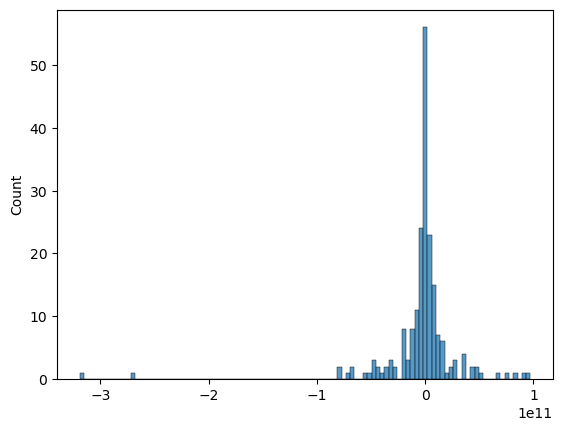

In [176]:
sns.histplot(Ey)

In [165]:
grad_x, 

array([[-9.9982903e-04, -1.0410157e-03, -1.3616655e-03, ...,
         1.6051790e-03,  2.2833974e-03,  2.9076776e-03],
       [ 8.7092601e-04,  8.1475038e-04,  6.4635201e-04, ...,
         3.1319630e-04,  6.6028477e-04,  1.0115094e-03],
       [ 1.1729908e-03,  1.2465855e-03,  1.3478559e-03, ...,
        -1.7250765e-03, -1.7596881e-03, -2.0648807e-03],
       ...,
       [-7.2582770e-05, -4.5442528e-05, -2.3229695e-05, ...,
         7.1562664e-04,  9.2988095e-04,  1.0468099e-03],
       [ 1.2878674e-03,  1.0067091e-03,  1.2756408e-03, ...,
        -5.4292654e-04, -6.2223617e-04, -6.5464916e-04],
       [ 1.6108506e-03,  1.5426292e-03,  1.6016233e-03, ...,
        -1.9279729e-03, -2.2354848e-03, -2.3094881e-03]], dtype=float32)

In [150]:
#create grid of lat and lon
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

def calculate_delta(lat1, lon1, lat2, lon2):
    radius = 6371.008 * 1e3

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    l = 2 * np.pi * radius
    
    delta_x = dlat * (l/360)
    delta_y = dlon * (l/360) * np.cos(np.radians(lat1))
    
    return delta_x, delta_y

d_x = []
d_y = []

for i in range(len(lat) - 1):
    for j in range(len(lon) - 1):
        lat1, lat2 = lat[i], lat[i + 1]
        lon1, lon2 = lon[j], lon[j + 1]
        
        delta_x, delta_y = calculate_delta(lat1, lon1, lat2, lon2)
        d_x.append(delta_x)
        d_y.append(delta_y)
        
        #area = delta_x * delta_y
        #areas[i, j] = area
delta_x = np.array(d_x)
delta_y = np.array(d_y)

lat_cropped_int =np.linspace(53.1, 89.7, 29)
lon_cropped_int = np.linspace(1.6, 357.6, 79)

In [145]:
delta_y.

(2291,)

In [114]:
grid = np.ones((10, 10))

In [116]:
grad_x, grad_y = np.gradient(grid)

In [131]:
np.linspace(1, 10, 10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [162]:
dy

array([300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 300859.50584048, 300859.50584048, 300859.50584048,
       300859.50584048, 3

In [160]:
delta_x

array([140335.84225913, 140335.84225913, 140335.84225913, ...,
       140335.84225913, 140335.84225913, 140335.84225913])

In [130]:
import numpy as np

# Create a 10x10 grid of ones
grid = np.ones((10, 10))

# Define varying delta_x and delta_y values
# For simplicity, let's say delta_x and delta_y vary linearly
delta_x = np.linspace(1, 10, 10)
delta_y = np.linspace(1, 5, 10)

# Compute the gradient of the grid with respect to delta_x and delta_y
# numpy.gradient allows us to pass the spacing between points as an argument
grad_y, grad_x = np.gradient(grid, delta_y, delta_x)

print("Grid:")
print(grid)
print("\nDelta X:")
print(delta_x)
print("\nDelta Y:")
print(delta_y)
print("\nGradient with respect to X:")
print(grad_x)
print("\nGradient with respect to Y:")
print(grad_y)


Grid:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

Delta X:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

Delta Y:
[1.         1.44444444 1.88888889 2.33333333 2.77777778 3.22222222
 3.66666667 4.11111111 4.55555556 5.        ]

Gradient with respect to X:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Gradient with respect to Y:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
